# Analyzing the India Covid-19 stats

## This notebook is highly motivated by https://github.com/k-sys/covid-19

Given the current focus on Covid-19, lets try and do some basic data analysis with whatever data is publicly available. As of now this notebook is India specific but of course the analysis techniques are applicable to any country, state, or geographic area as long as the data is suitably available.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output


## Read the csv file from an URL
Lets first get the data. The data from the https://www.covid19india.org/ project is available at https://api.covid19india.org/ and for the most part we will use the CSV files only. Kudos to this volunteer team that has done a wonderful job of verifying and then analysing the crowdsourced data of country wide Covid-19 related reports and statistics. 

In [34]:
# if you have downloaded the file already
# filename = "confirmed.csv"

def skiplogic(index, compare):
    if index == 0:
       return False
    if index % 3 == compare:
       return False
    return True

# but it is more convenient if you can download it right now!
#filename = "http://api.covid19india.org/states_daily_csv/confirmed.csv"
filename = "https://api.covid19india.org/csv/latest/state_wise_daily.csv"
#data = pd.read_csv(filename) # from now on 'data' is god!
data_deceased = pd.read_csv(filename, skiprows= lambda x: skiplogic(x,0)) # from now on 'data' is god!
data_confirmed = pd.read_csv(filename, skiprows= lambda x: skiplogic(x,1)) # from now on 'data' is god!
data_recovered = pd.read_csv(filename, skiprows= lambda x: skiplogic(x,2)) # from now on 'data' is god!

print(data_recovered)

# Some global variables
# title fonts
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 20,
        }

# axis font
myfontsize=16

# standard deviation for gaussian distribution
std_dev=2

# days to use as window for rolling calculations
window=7


          Date     Status     TT  AN    AP  AR    AS   BR  CH   CT  ...   PB  \
0    14-Mar-20  Recovered      9   0     0   0     0    0   0    0  ...    0   
1    15-Mar-20  Recovered      4   0     0   0     0    0   0    0  ...    0   
2    16-Mar-20  Recovered      1   0     0   0     0    0   0    0  ...    0   
3    17-Mar-20  Recovered      1   0     0   0     0    0   0    0  ...    0   
4    18-Mar-20  Recovered      0   0     0   0     0    0   0    0  ...    0   
..         ...        ...    ...  ..   ...  ..   ...  ...  ..  ...  ...  ...   
122  14-Jul-20  Recovered  20977  20  1003   8   757  655  23   73  ...   77   
123  15-Jul-20  Recovered  20646   1   911   0   715  514  13   49  ...  204   
124  16-Jul-20  Recovered  22867   3  1015   0   666  568  17  127  ...  410   
125  17-Jul-20  Recovered  17476   0   905  22   551  896   4   61  ...   96   
126  18-Jul-20  Recovered  23552   0  1465  99  1060  774   5  146  ...   81   

      RJ  SK    TN    TG  TR    UP  UT 

## Bar plot of daily count

          Date     Status     TT  AN    AP  AR    AS    BR  CH   CT  ...   PB  \
0    14-Mar-20  Confirmed     81   0     1   0     0     0   0    0  ...    1   
1    15-Mar-20  Confirmed     27   0     0   0     0     0   0    0  ...    0   
2    16-Mar-20  Confirmed     15   0     0   0     0     0   0    0  ...    0   
3    17-Mar-20  Confirmed     11   0     0   0     0     0   0    0  ...    0   
4    18-Mar-20  Confirmed     37   0     0   0     0     0   0    0  ...    1   
..         ...        ...    ...  ..   ...  ..   ...   ...  ..  ...  ...  ...   
122  14-Jul-20  Confirmed  29917   5  1916  75   859  1432  12  114  ...  333   
123  15-Jul-20  Confirmed  32607   5  2432  29  1088  1320  19  177  ...  288   
124  16-Jul-20  Confirmed  35468   4  2593  52   892  1385  16  198  ...  295   
125  17-Jul-20  Confirmed  34820   0  2602  66  1218  1742  25  249  ...  348   
126  18-Jul-20  Confirmed  37407   0  3963  41  1117  1667  31  243  ...  350   

      RJ  SK    TN    TG   

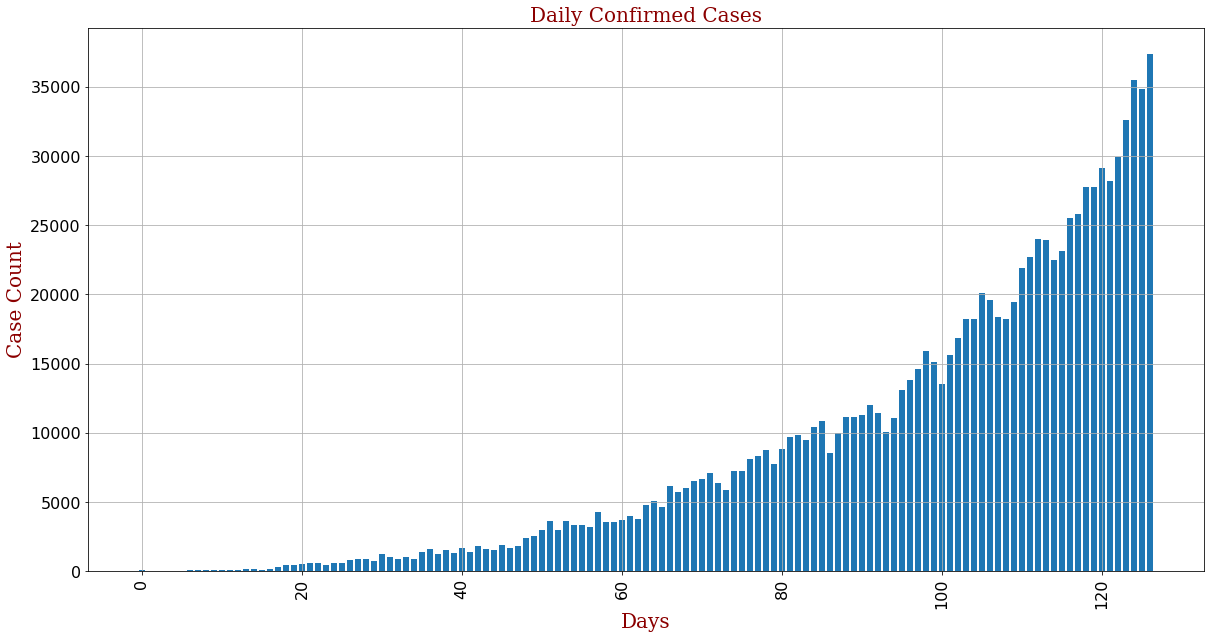

In [39]:
from scipy.stats import norm

confirmed = data_confirmed
print(confirmed)

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']
#xmin, xmax = 0, 80

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)
print(confirmed)

#mean,std=norm.fit(confirmed['TT'])
#print("mean: " + str(mean) + " std. dev.: " + str(std))

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)
plt.title('Daily Confirmed Cases', fontdict=font)
plt.xlabel('Days', fontdict=font)
plt.ylabel('Case Count', fontdict=font)
#plt.xlim(xmin, xmax)

#plt.plot(confirmed['TT'])
plt.bar(confirmed['TT'].index, confirmed['TT'])
#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 1000)
#y = 150000*norm.pdf(x, 60, 15)
#print(x)
#print(y)
#plt.plot(x, y, 'r-')
plt.show()


## Warmup, try to get a plot of daily counts of some specific states and the country total.
This is just to get warmed up and really does not involve any analysis but just plots the data so that it can be visualized and hence better understood.

Index(['Date', 'Status', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN',
       'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD',
       'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN',
       'TG', 'TR', 'UP', 'UT', 'WB', 'UN'],
      dtype='object')


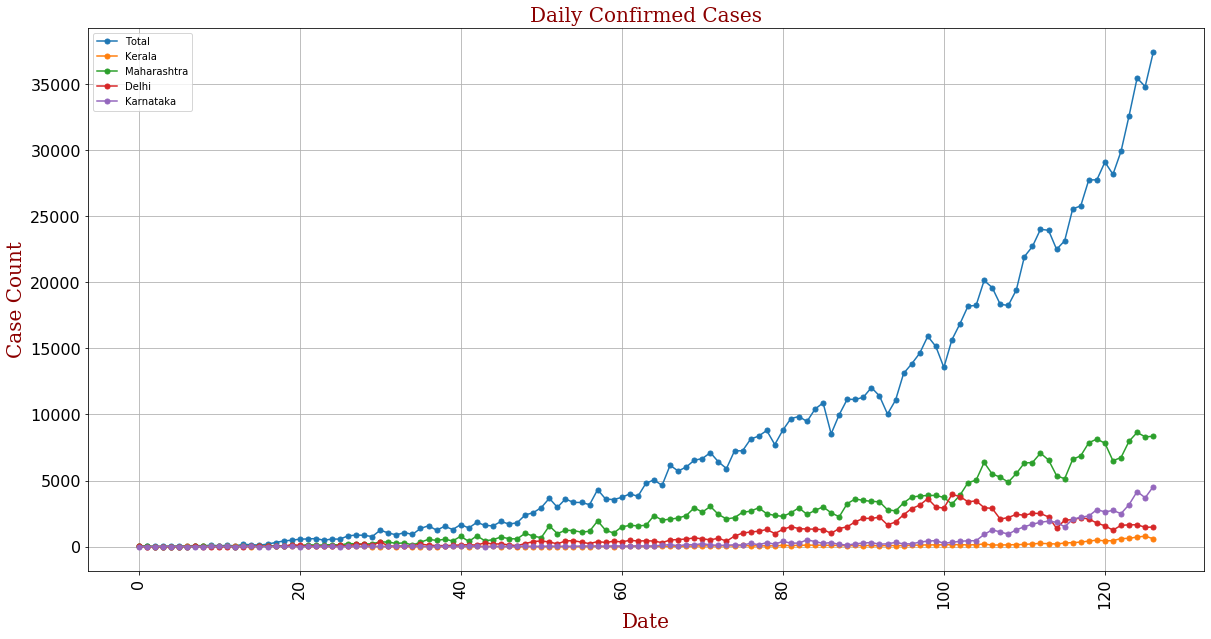

In [44]:
confirmed = data_confirmed
print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)

plt.title('Daily Confirmed Cases', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

plt.plot(dates.index, confirmed['TT'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['KL'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['MH'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['DL'], marker='o', markersize=5)
plt.plot(dates.index, confirmed['KA'], marker='o', markersize=5)
plt.legend(['Total', 'Kerala', 'Maharashtra', 'Delhi', 'Karnataka'])

#confirmed.cumsum(axis=0)



## Daily count is too jittery. Lets try and smooth it - for one state. 
Daily count is fine, but then the daily samples are too jittery and the disease does not care much about dates. Hence, lets try and smooth the data assuming that, like many things in life, the data follows a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). We can play around with the standard deviation but we stick with a standard deviation of 2 (the lower the standard deviation, the steeper the curve).

          TT   AN      AP    AR      AS      BR    CH     CT    DN   DD  ...  \
0       42.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
1       35.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
2       30.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
3       29.0  0.0     0.0   0.0     0.0     0.0   0.0    0.0   0.0  0.0  ...   
4       32.0  0.0     1.0   0.0     0.0     0.0   1.0    0.0   0.0  0.0  ...   
..       ...  ...     ...   ...     ...     ...   ...    ...   ...  ...  ...   
122  30912.0  4.0  2150.0  41.0   920.0  1293.0  18.0  166.0  19.0  0.0  ...   
123  32440.0  4.0  2394.0  47.0   990.0  1403.0  19.0  184.0  22.0  0.0  ...   
124  33689.0  3.0  2610.0  50.0  1034.0  1471.0  21.0  198.0  25.0  0.0  ...   
125  34799.0  2.0  2837.0  51.0  1063.0  1542.0  22.0  212.0  28.0  0.0  ...   
126  35624.0  1.0  3064.0  50.0  1097.0  1590.0  25.0  228.0  32.0  0.0  ...   

        PB     RJ    SK      TN      TG

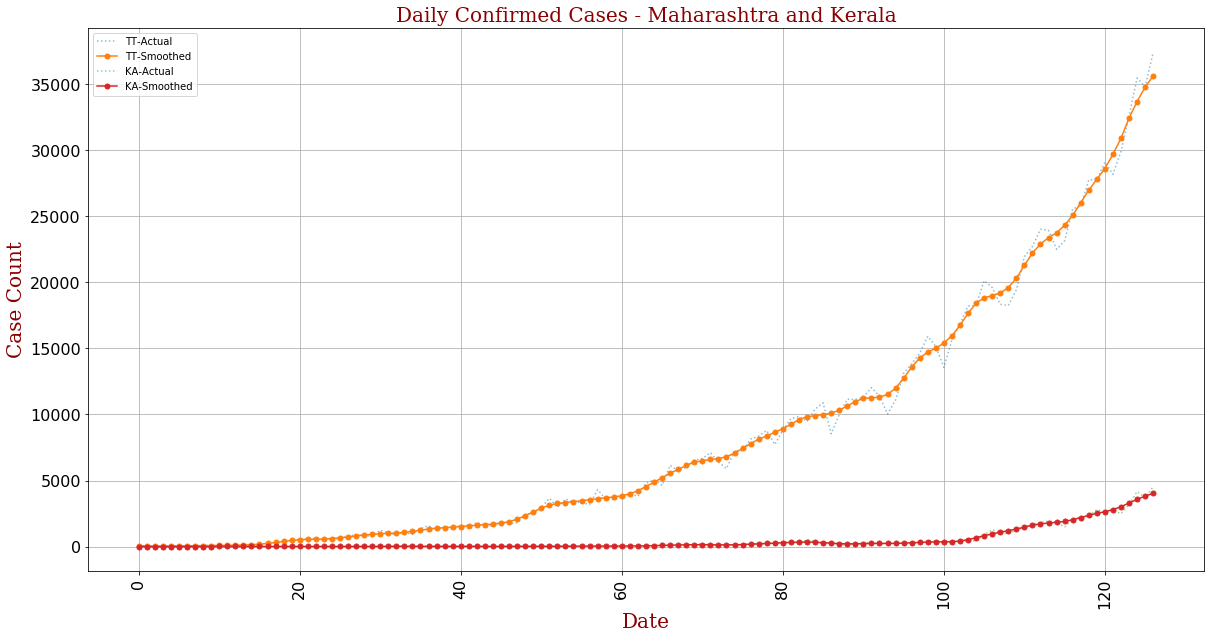

In [48]:
confirmed = data_confirmed
#print(confirmed.columns)
#print(confirmed.describe())


# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date'], axis=1)
smoothed = confirmed.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=std_dev).round()
print(smoothed)

fig=plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.xticks(fontsize=myfontsize)
plt.yticks(fontsize=myfontsize)
plt.grid(True)

plt.title('Daily Confirmed Cases - India and Karnataka', fontdict=font)
plt.xlabel('Date', fontdict=font)
plt.ylabel('Case Count', fontdict=font)

plt.plot(dates.index, confirmed['TT'], linestyle=':', alpha=0.5)
plt.plot(dates.index, smoothed['TT'], marker='.', markersize=10)
plt.plot(dates.index, confirmed['KA'], linestyle=':', alpha=0.5)
plt.plot(dates.index, smoothed['KA'], marker='.', markersize=10)

plt.legend(['TT-Actual', 'TT-Smoothed', 'KA-Actual', 'KA-Smoothed'])




Well I lied! I said one state but plotted for two but then anything to do with epidemics, has to have a plot for Kerala :-)

## Function to plot.
Just like any programming, one soon realizes that there are pieces of code that will be repeated a lot, and that would be perfect for writing a function for.

In [113]:
#def plot_states(dates, inputdata, index_list, legend_list, title, xlabel, ylabel,linestyle='-', legend_loc=2):
def plot_states(dates, inputdata, index_list, legend_list, title, xlabel, ylabel,legend_loc=2, **plt_kwargs):
    fig = plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xticks(fontsize=myfontsize)
    plt.yticks(fontsize=myfontsize)
    plt.grid(True)
    plt.title(title, fontdict=font)
    plt.xlabel(xlabel, fontdict=font)
    plt.ylabel(ylabel, fontdict=font)
    
    markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', '*', 'D']
    marker_count = len(markers)
    count=0
    for index in index_list:
        plt.plot(dates, inputdata[index], marker=markers[count%marker_count], **plt_kwargs)
        count = count+1
    plt.legend(legend_list, loc=legend_loc)
    return plt.gca()


## Cumulative, daily, and smoothed daily plots for the top 10 states with highest total cases.
It is not that useful to plot all states. For easier consumption, it is better to limit it to the top states, i.e., states which has the highest current number of covid positives to date.

In [114]:
confirmed = data_confirmed
print(confirmed.columns)
#print(confirmed.describe())

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=confirmed['Date']

# drop the date column (axis = 1 means column)
confirmed=confirmed.drop(['Date', 'Status'], axis=1)

smoothed = confirmed.rolling(window, 
                             win_type='gaussian',
                             min_periods=1, 
                             center=True).mean(std=2).round()
#ewm = confirmed.ewm(span = 7).mean().round()

cumulative=confirmed.cumsum(axis=0)
print(cumulative)

# Lets get the 10 states with the highest number of cases
length=len(cumulative.index)
#print(length)
#last_row = cumulative.iloc[-1]
#print(last_row)
#print(cumulative.tail(1))

# sort using column values in the last row
cumulative = cumulative.sort_values(by=length-1, axis=1, ascending=False)
print("Contents of Sorted Dataframe based on a single row index label " + str(length-1))
top_ten = cumulative[cumulative.columns[1:11]]
top_5 = cumulative[cumulative.columns[1:6]]

Index(['Date', 'Status', 'TT', 'AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DN',
       'DD', 'DL', 'GA', 'GJ', 'HR', 'HP', 'JK', 'JH', 'KA', 'KL', 'LA', 'LD',
       'MP', 'MH', 'MN', 'ML', 'MZ', 'NL', 'OR', 'PY', 'PB', 'RJ', 'SK', 'TN',
       'TG', 'TR', 'UP', 'UT', 'WB', 'UN'],
      dtype='object')
          TT   AN     AP   AR     AS     BR   CH    CT   DN  DD  ...    PB  \
0         81    0      1    0      0      0    0     0    0   0  ...     1   
1        108    0      1    0      0      0    0     0    0   0  ...     1   
2        123    0      1    0      0      0    0     0    0   0  ...     1   
3        134    0      1    0      0      0    0     0    0   0  ...     1   
4        171    0      1    0      0      0    0     0    0   0  ...     2   
..       ...  ...    ...  ...    ...    ...  ...   ...  ...  ..  ...   ...   
122   937461  171  33019  462  18565  18853  600  4379  543   0  ...  8511   
123   970068  176  35451  491  19653  20173  619  4556  560   0  ...  879

## Now lets plot the cumulative, daily, and smoothed daily for the top 10 states

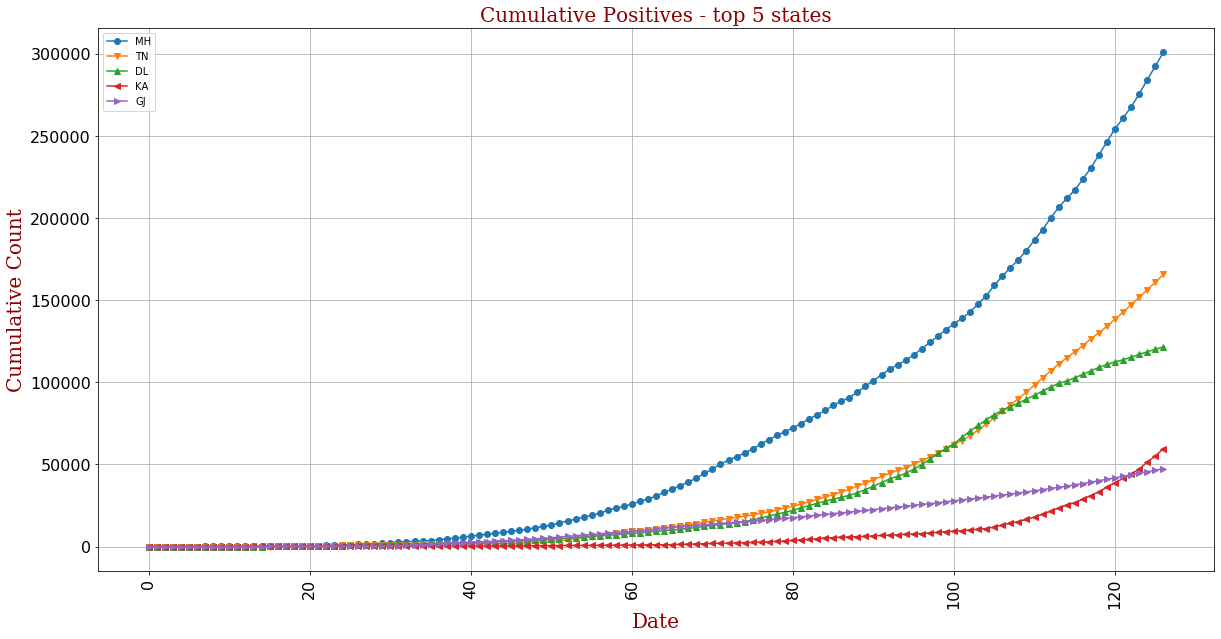

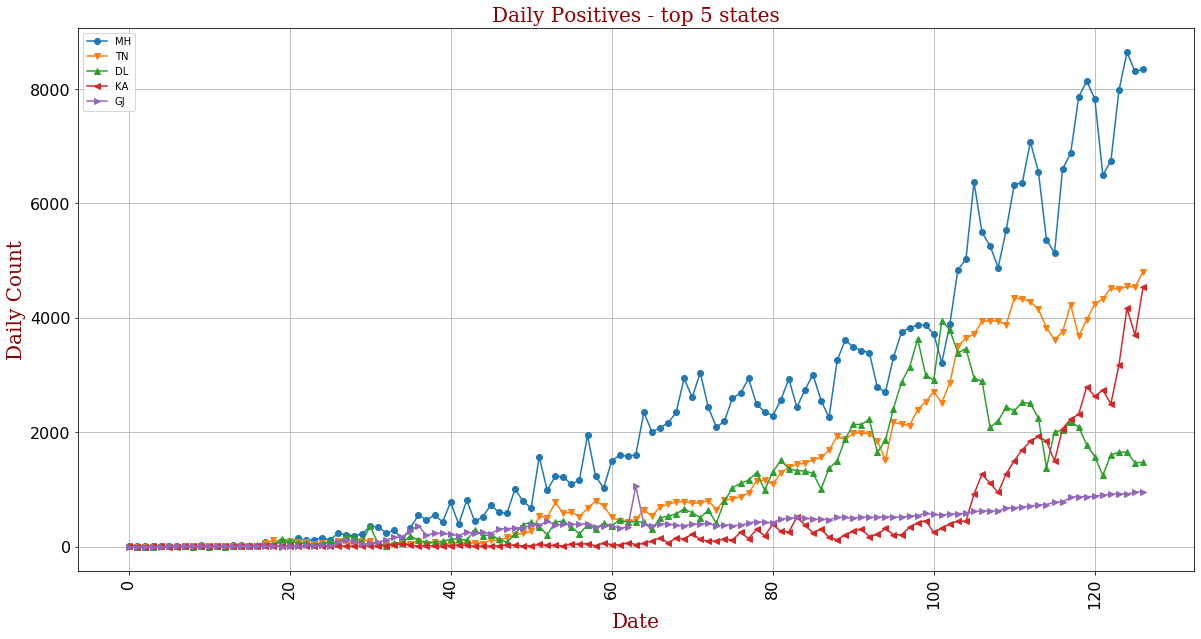

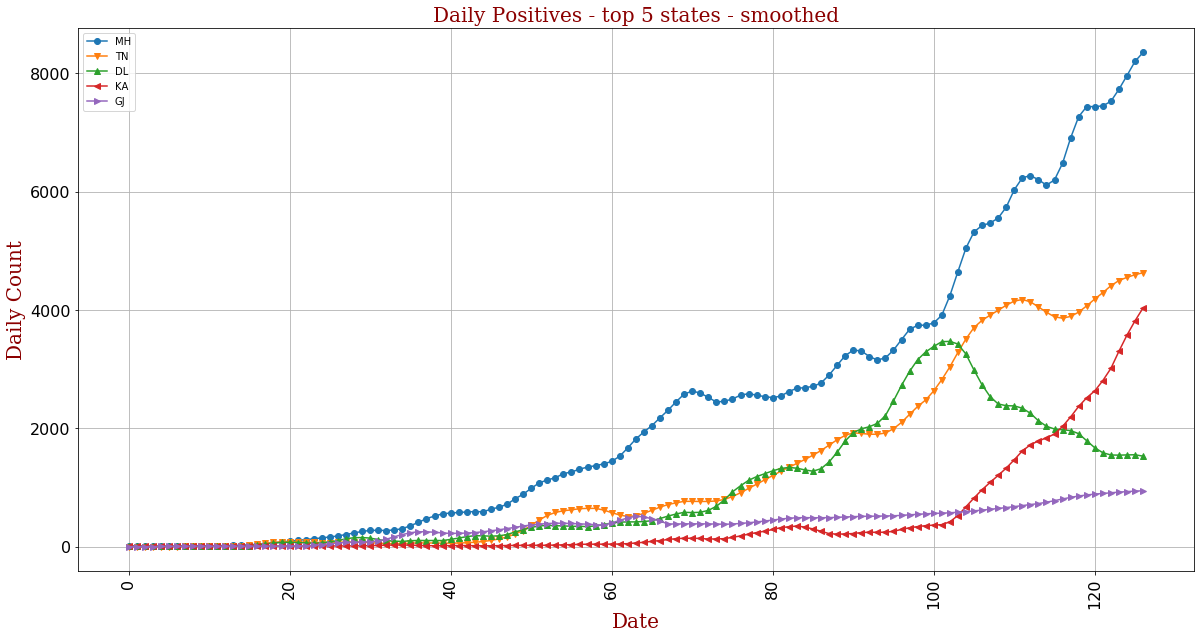

In [115]:
index_list = top_5.columns
legend_list = index_list
plot_states(dates.index, cumulative, index_list, legend_list, 'Cumulative Positives - top 5 states', 'Date', 'Cumulative Count')
plot_states(dates.index, confirmed, index_list, legend_list, 'Daily Positives - top 5 states', 'Date', 'Daily Count')
plot_states(dates.index, smoothed, index_list, legend_list, 'Daily Positives - top 5 states - smoothed', 'Date', 'Daily Count')
#plot_states(dates, ewm, index_list, legend_list, 'Daily Positives - top 10 states - ewm', 'Date', 'Daily Count')

## Let's try to get the Levitt's metric
$H(t) = \frac{X(t)}{X(t-1)}$, where $X(t)$ is cumulative case count until day $t$ (can be deaths or cases)

### First for confirmed cases

(50, 132.25)

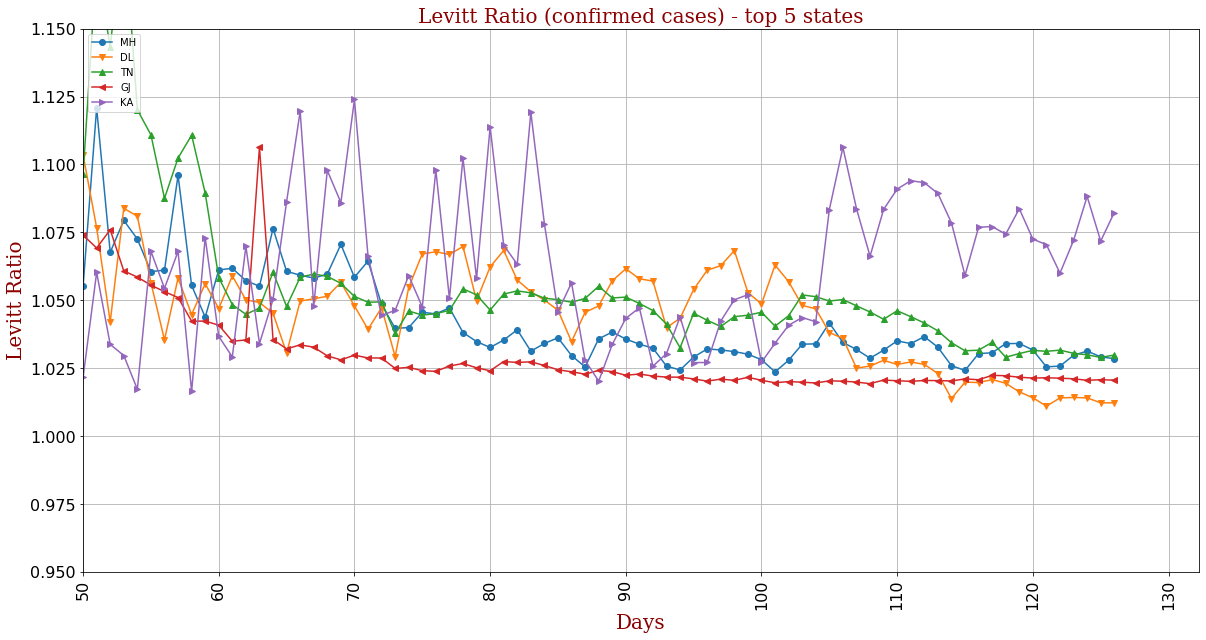

In [131]:
#print(cumulative)
levitt = cumulative.pct_change().add(1)
#print(cumulative)
#print(levitt)
#print(percent_change)

index_list = top_5.columns
legend_list = index_list
ax = plot_states(dates.index, levitt, index_list, legend_list, 'Levitt Ratio (confirmed cases) - top 5 states', 'Days', 'Levitt Ratio')
ax.set_ylim(0.95, 1.15)
ax.set_xlim(left=50)


### Now the Levitt's ratio for deaths

        TT  AN   AP  AR  AS   BR  CH  CT  DN  DD  ...   PB   RJ  SK    TN  \
0        2   0    0   0   0    0   0   0   0   0  ...    0    0   0     0   
1        2   0    0   0   0    0   0   0   0   0  ...    0    0   0     0   
2        2   0    0   0   0    0   0   0   0   0  ...    0    0   0     0   
3        3   0    0   0   0    0   0   0   0   0  ...    0    0   0     0   
4        3   0    0   0   0    0   0   0   0   0  ...    0    0   0     0   
..     ...  ..  ...  ..  ..  ...  ..  ..  ..  ..  ...  ...  ...  ..   ...   
122  24316   0  408   3  50  143  10  20   1   0  ...  213  524   0  2099   
123  24930   0  452   3  52  157  11  20   2   0  ...  221  530   0  2167   
124  25610   0  492   3  54  167  11  21   2   0  ...  230  538   0  2236   
125  26286   0  534   3  55  173  11  24   2   0  ...  239  546   0  2315   
126  26829   0  586   3  57  177  12  24   2   0  ...  246  553   0  2403   

      TG  TR    UP  UT    WB  UN  
0      0   0     0   0     0   0  
1    

(50, 132.25)

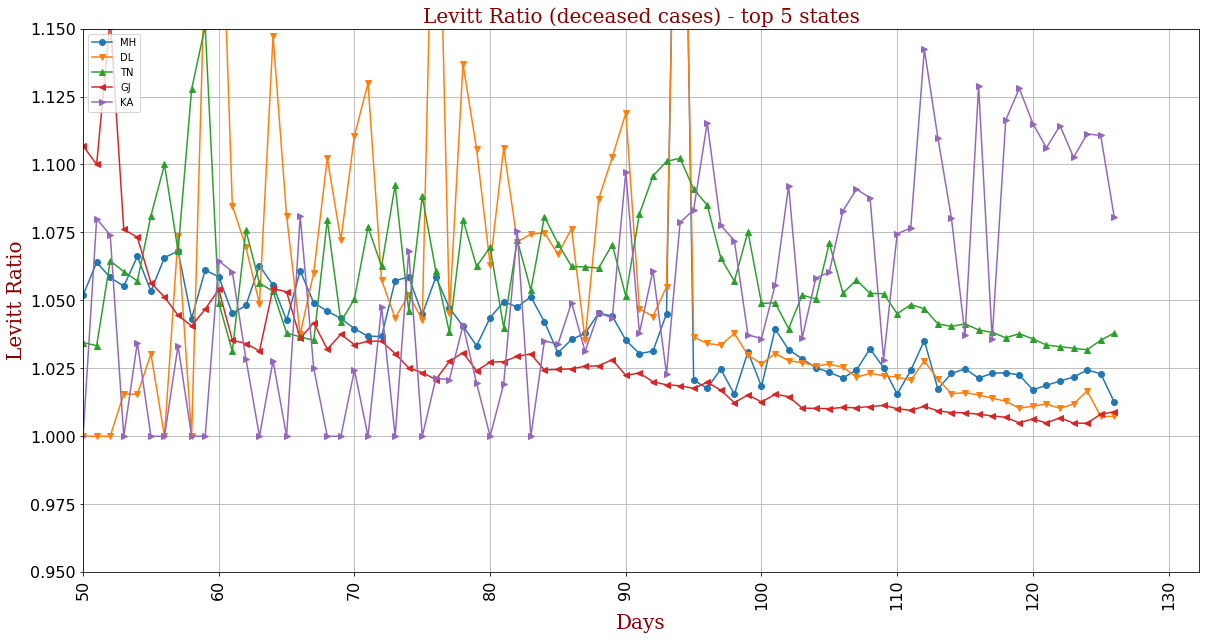

In [132]:
deaths = data_deceased

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings
dates=deaths['Date']

# drop the date and status column (axis = 1 means column)
deaths=deaths.drop(['Date', 'Status'], axis=1)

# cumulative deaths
cum_deaths=deaths.cumsum(axis=0)
print(cum_deaths)

# Lets get the 10 states with the highest number of cases
length=len(cum_deaths.index)

# sort using column values in the last row
cum_deaths = cum_deaths.sort_values(by=length-1, axis=1, ascending=False)
print("Contents of Sorted Dataframe based on a single row index label " + str(length-1))
top_5 = cum_deaths[cum_deaths.columns[1:6]]

levitt_death = cum_deaths.pct_change().add(1)
#print(cumulative)
print(levitt_death)
#print(percent_change)

index_list = top_5.columns
legend_list = index_list
ax = plot_states(dates.index, levitt_death, index_list, legend_list, 'Levitt Ratio (deceased cases) - top 5 states', 'Days', 'Levitt Ratio')
ax.set_ylim(0.95, 1.15)
ax.set_xlim(left=50)

## Lets try some fits for these curves.

In [133]:
from sklearn.linear_model import LinearRegression

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print('Coefficient of determination: ', r_sq)


Coefficient of determination:  0.715875613747954


Intercept:  0.9453972982235074
Slope/Coefficent:  [0.00122071]
Coefficient of determination:  0.47302608136205415


(0.95, 1.14)

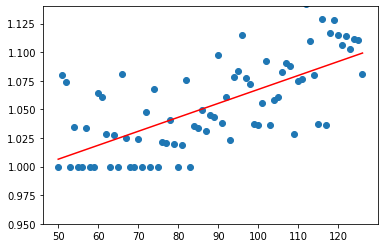

In [180]:
from sklearn.linear_model import LinearRegression

# making a copy of the dates since we are going to remove that column
# since that is the only column with strings

X = dates.index[50:].values.reshape((-1, 1))
Y = levitt_death['KA'][50:]
#print(X)
#print(Y)

#X=dates.index.values.reshape((-1, 1))
#Y=(levitt_death['MH'].replace([np.inf, -np.inf], np.nan)).dropna()
#valid_indices = Y.index
#print(valid_indices)
#X=X[valid_indices]
#print(Y)

model = LinearRegression().fit(X, Y)

r_sq = model.score(X, Y)
print("Intercept: ", model.intercept_)
print("Slope/Coefficent: ", model.coef_)
print('Coefficient of determination: ', r_sq)

Y_pred = model.predict(X)

plt.scatter(X, Y)
plt.plot(X, Y_pred, c = 'r')
ax = plt.gca()
ax.set_ylim(0.95,1.14)




